In [1]:

#### training the CNN2 for regression, ( using gpu is time-saving )

import torch
from functions import *
import time
from torch import nn
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftshift, ifftshift
import random
import numpy as np

data = np.load('data_40000_08.npz')
#data = np.load('./data_40000_all_09.npz')
Fb = 0.8
S=data['S']
#y = data['RC'];y1 = data['FC'];Y=data['CC'];
F = data['F'];a1 =data['A1'];a2 =data['A2'];
#RC=data['RC'];
RH = data['RH']
A12 =[];F_RH=[];
xRH =[];
for i in range(len(S)):
    if RH[i] ==1:#RC[i] ==1 and F[i]>Fb:
        xRH.append(S[i][:])
        A12.append([a1[i],a2[i]]);
        F_RH.append(F[i])

print('length of HR',len(F_RH))

xRH = np.concatenate(xRH);
xRH = np.reshape(xRH, (int(len(xRH)/160),160));

# formulating the database
x = xRH
y = A12

X1 = np.array(x); Y1 = np.array(y)
FF = np.array(F_RH)#[:4000]
occ = int(0.8*len(x)) # 80% ans training data
batch_size = 20

tra_x = X1[:occ]
tra_y = Y1[:occ]
tra_F = FF[:occ]

#print(tra_x.shape)
tst_x = X1[occ:]
tst_y = Y1[occ:]
tst_F = FF[occ:]
tra_num = tra_x.shape[0]
tst_num = tst_x.shape[0]

occ_posi = round(np.sum(tra_y)/tra_num,3)

batch_num = tra_num // batch_size
tst_batch_num = tst_num // batch_size
print('tra_batch_num',batch_num,"tst_batch_num",tst_batch_num)

#tra_x,tst_x=for_cnn(tra_x,tst_x) # extending to 2d
#1d
tra_x = np.expand_dims(tra_x, -1);#1d
tra_x= np.transpose(tra_x, [0, 2, 1])#为了之后使得tra =【batch，batchsize，1，160】
tst_x = np.expand_dims(tst_x, -1);
tst_x= np.transpose(tst_x, [0, 2, 1])

tra_x = to_batch(tra_x, batch_size)  #
tra_y = to_batch(tra_y, batch_size)
tst_x = to_batch(tst_x, batch_size)
tst_y = to_batch(tst_y, batch_size)
tra_fidelity = to_batch(tra_F, batch_size)
tst_fidelity = to_batch(tst_F, batch_size)


#device ='cpu'# 'cuda' #若未配置cuda环境请将device改为'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# convert to tensor
tra_x = torch.tensor(tra_x).to(device).float()
tra_y = torch.tensor(tra_y).to(device).float()#long() for entropycross()
tst_x = torch.tensor(tst_x).to(device).float()
tst_y = torch.tensor(tst_y).to(device).float()



length of HR 8572
tra_batch_num 342 tst_batch_num 85
cpu


In [2]:
#### 1d
import torch as t
from torch import nn
from torch.nn import functional as F
class ResidualBlock(nn.Module):
    """
    实现子 module：Residual Block
    """
    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()

        # 由于 Residual Block 分为左右两部分，因此定义左右两边的 layer
        # 定义左边
        self.left = nn.Sequential(
            # Conv2d 参数：in_channel,out_channel,kernel_size,stride,padding
            nn.Conv1d(inchannel, outchannel, 3, stride, 1, bias=False),
            #(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv1d(outchannel, outchannel, 3, 1, 1, bias=False),
            nn.BatchNorm1d(outchannel)
            )
        # 定义右边
        self.right = shortcut

    def forward(self, x):
        out = self.left(x)
        residual = x if self.right is None else self.right(x)  # 检测右边直连的情况
        out += residual
        return F.relu(out)
class ResNet(nn.Module):
    """
    实现主 module：ResNet34
    ResNet34 包含多个 layer，每个 layer 又包含多个 residual block
    用子 module 实现 residual block，用 _make_layer 函数实现 layer
    """

    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        # 前几层图像转换
        fm = 16
        self.pre = nn.Sequential(
            nn.Conv1d(1, fm, 3, 1, 1, bias=False),
            nn.BatchNorm1d(fm), #nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3),#kernel_size, stride=None, padding
        )

        # 重复的 layer 分别有 3，4，6，3 个 residual block

        self.layer1 = self._make_layer(fm, fm*2, 3)
        self.layer2 = self._make_layer(fm*2, fm*4, 4, stride=2)
        self.layer3 = self._make_layer(fm*4, fm*8, 6, stride=2)
        self.layer4 = self._make_layer(fm*8, fm*8, 3, stride=2)

        # 分类用的全连接
        self.fc = nn.Linear(fm*8, num_classes)

    def _make_layer(self, inchannel, outchannel, block_num, stride=1):
        """
        构建 layer，包含多个 residual block
        """
        shortcut = nn.Sequential(
            nn.Conv1d(inchannel, outchannel, 1, stride, bias=False),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(outchannel)
            )

        layers = []
        layers.append(ResidualBlock(inchannel, outchannel, stride, shortcut))

        for i in range(1, block_num):
            layers.append(ResidualBlock(outchannel, outchannel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pre(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool1d(x, 7)
        x = x.view(x.size(0), -1)

        return self.fc(x)


In [3]:
def to_batch(x, batch_size):

    num = x.shape[0]
    batch_num = num / batch_size
    batch_num = int(batch_num)

    x = x[:batch_num * batch_size]
    shape = list(x.shape)
    del shape[0]
    shape.insert(0, batch_size)
    shape.insert(0, batch_num)
    y = np.zeros(shape)

    for i in range(batch_num):
        y[i] = x[batch_size * i : batch_size * (i + 1)]
    return y

def to_matrix(x):
  # turn to 2d
    x = np.expand_dims(x, -1)
    one = np.ones([x.shape[0], 1, 160])#1,160 for 1d
    x = one * x
    x = x + np.transpose(x, [0, 2, 1])
    x = np.expand_dims(x, 1)
    return x

def for_cnn(tra_x,tst_x):
    # 使用卷积请运行下方三行代码
    tra_x = to_matrix(tra_x)  # 转化为160*160
    tst_x = to_matrix(tst_x)
    return tra_x,tst_x

In [4]:

drop = 0
epochs = 30
learning_rate = 0.0001

#import AlexNet
#from model_ResNet import ResNet_34
#net = model.Conv1d.to(device)
#net = AlexNet().to(device)
net = ResNet().to(device)
#net = model.Conv.to(device)
print(tra_x.shape)
loss = torch.nn.MSELoss().to(device)# 均方差计算loss
opt = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001)


tra_loss_list = []
tst_loss_list = []
tra_acc_list = []
tst_acc_list = []
tst_F_list =[]
tra_F_list=[]

Epoch=[]

Tra_loss_batch=np.zeros(shape=(epochs,batch_num))
Tst_loss_batch=np.zeros(shape=(epochs,tst_batch_num))

Tra_F_batch=np.zeros(shape=(epochs,batch_num))
Tst_F_batch=np.zeros(shape=(epochs,tst_batch_num))

F_org_tra = np.zeros(shape=(epochs,batch_num))
F_org_tst = np.zeros(shape=(epochs,tst_batch_num))
NN1 = batch_num //10

for epoch in range(epochs):#epochs
    # initialization
    Epoch.append(epoch);num = 0;total_loss = 0;
    j=random.randint(0, 3)
    start = time.time()
    jj=0
    for batch in range(batch_num):
        net.train()
        logits = net(tra_x[batch])
        tra_loss = loss(logits, tra_y[batch])#每个batch的均方差的值[\Sigma(y_pre-y_real)^2]/batch_num
        tra_value = logits.cpu().detach().numpy()

        
        if batch%NN1==0:
          #batch<NN:

        ### fidelity
          F_org = tra_fidelity[batch] # org fidelity
          prediction = logits
          y_pred = prediction.cpu().detach().numpy() 

        #tst_loss = loss(prediction, tra_y[i])
          y_org = tra_y[batch].cpu().numpy()
          x_org = tra_x[batch].cpu().numpy()

          SS = x_org
          a1 = y_pred[j][0];a2 = y_pred[j][1];#在这个batch中取任意第j个作为这个batch的平均
      
          #Si= SS[j][0][0]-SS[j][0][0][0]*0.5
          Si= SS[j][0]
          F_pre = produce_fidelity(a1,a2,Si)# 求出预测的fidelity

          Tra_F_batch[epoch][jj] = F_pre# 
          F_org_tra [epoch][jj] = F_org[j]
          jj+=1
         
        
        opt.zero_grad()# 梯度清0
        tra_loss.backward()# 自动对loss梯度
        opt.step()#优化参数
        total_loss += tra_loss.item()#把每个batch的平均loss累加
        
        Tra_loss_batch[epoch][batch] = tra_loss.item()

    #print(tra_loss.item())
    end = time.time()
    loss_ave = total_loss / (batch_num)# average of every loss *batch_size
    tra_loss_list.append(loss_ave)
    
    F_ave= np.sum(np.abs(np.array(Tra_F_batch[epoch])-np.array(F_org_tra [epoch])))/(jj)#average fidelity difference for every epoch
    tra_F_list.append(F_ave)
    

    net.eval()
    num = 0
    total_loss = 0

    NN2 = tst_batch_num//10
    jj1=0
 

    for batch in range(tst_batch_num):

        tst_logits = net(tst_x[batch])
        tst_loss = loss(tst_logits,tst_y[batch])#torch.tensor(tst_y[batch]).to(device).long())
        total_loss += tst_loss.item()

     
        if batch%NN2==0:
          # taking the first element of fiset 10 batch in every epoch for calculating the average vaule
        ### fidelity
          F_org = tst_fidelity[batch] # org fidelity
          prediction = tst_logits
          y_pred = prediction.cpu().detach().numpy() 

        #tst_loss = loss(prediction, tra_y[i])
          y_org = tst_y[batch].cpu().numpy()
          x_org = tst_x[batch].cpu().numpy()

          SS = x_org
          a1 = y_pred[j][0];a2 = y_pred[j][1];#在这个batch中取任意第j个作为这个batch的平均
          
      
          Si= SS[j][0]
          F_pre = produce_fidelity(a1,a2,Si)# 求出预测的fidelity
          #print(a1,a2,tst_y[batch][j],F_pre)

          Tst_F_batch[epoch][jj1] = F_pre# 
          F_org_tst [epoch][jj1] = F_org[j]
          jj1+=1
     
       
        Tst_loss_batch[epoch][batch] = tst_loss.item()

    loss_ave_tes = total_loss / (tst_batch_num)#*batch_size
    tst_loss_list.append(loss_ave_tes)

    F_ave= np.sum(np.abs(np.array(Tst_F_batch[epoch])-np.array(F_org_tst[epoch])))/(jj1)
    tst_F_list.append(F_ave)
    
    print('Epoch:',epoch,'train_loss_average:',loss_ave,'test_loss_average:',loss_ave_tes,'tst fidelity_average:',F_ave)

print(jj,jj1)
   



torch.Size([342, 20, 1, 160])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 train_loss_average: 434.0424360308731 test_loss_average: 294.40701222139245 tst fidelity_average: 0.04759579083708578
Epoch: 1 train_loss_average: 199.77769764682702 test_loss_average: 128.24379021139706 tst fidelity_average: 0.02644449828281464
Epoch: 2 train_loss_average: 74.29646763048675 test_loss_average: 38.56927521649529 tst fidelity_average: 0.04106851090992391
Epoch: 3 train_loss_average: 18.510685701816403 test_loss_average: 5.741275989308077 tst fidelity_average: 0.027006075075799097
Epoch: 4 train_loss_average: 3.316281881597307 test_loss_average: 1.5298485314144807 tst fidelity_average: 0.004424228859318358
Epoch: 5 train_loss_average: 0.9818179415680511 test_loss_average: 0.62324657405124 tst fidelity_average: 0.0004620843299948789
Epoch: 6 train_loss_average: 0.7266057302293024 test_loss_average: 0.5461056772400351 tst fidelity_average: 0.00019958236487046835
Epoch: 7 train_loss_average: 0.6970170520638165 test_loss_average: 0.5227014010443407 tst fidelity_avera

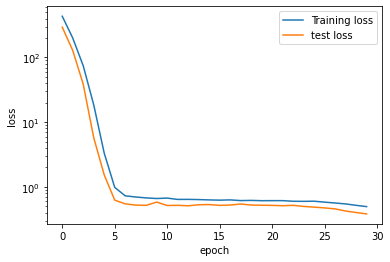

In [6]:

plt.figure()
#plt.title(r'$F_b = 0.9,P = 6$')
plt.plot(Epoch,tra_loss_list,label='Training loss')
plt.plot(Epoch,tst_loss_list,label='test loss')
plt.legend()
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


np.savez('regress1d.npz',
         Tra_loss_batch=Tra_loss_batch,
         Tst_loss_batch=Tst_loss_batch,
         tra_loss_list=tra_loss_list,
         tst_loss_list=tst_loss_list,
         Tst_F_batch=Tst_F_batch,
         Tra_F_batch = Tra_F_batch,
         F_org_tra=F_org_tra,
         F_org_tst = F_org_tst,
         tra_F_list=tra_F_list,
         tst_F_list=tst_F_list,
         )
torch.save(net.state_dict(),"regress1d.pth")

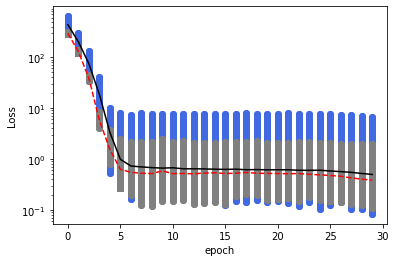

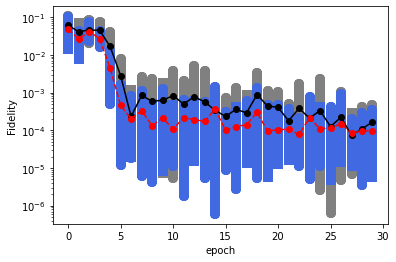

In [7]:

plt.figure()
for i in range(epochs):
  epp=[]
  epp1=[]
  for j in range(len(Tra_loss_batch[i])):
    epp.append(i)
  for j in range(len(Tst_loss_batch[i])):
    epp1.append(i)
    
  #print(len(Tra_loss_batch[i]),len(epp))
  plt.plot(epp,Tra_loss_batch[i],lw=7,color='royalblue')
  plt.plot(epp1,Tst_loss_batch[i],lw=7,color='grey')

plt.plot(Epoch,tra_loss_list, label='train loss', color='black')
plt.plot(Epoch,tst_loss_list, label='train loss', color='red',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Loss')


plt.figure()
for i in range(len(Tra_F_batch)):#epochs
  epp=[]
  for j in range(len(Tra_F_batch[i])):
    epp.append(i)
  plt.plot(epp[:int(batch_num//NN1)],np.abs(Tra_F_batch[i]-F_org_tra[i])[:int(batch_num//NN1)],lw=10,color='grey')
  #print(np.abs(Tra_F_batch[i]-F_org_tra[i])[:10])
for i in range(len(Tst_F_batch)):#epochs
  epp1=[]
  #F_org = tst_fidelity[i] 
  for j in range(len(Tst_F_batch[i])):
    epp1.append(i)
  #print(epp1[:7],np.abs(Tst_F_batch[i]-F_org_tst[i])[:7])
  plt.plot(epp1[:int(tst_batch_num//NN2)],np.abs(Tst_F_batch[i]-F_org_tst[i])[:int(tst_batch_num//NN2)],lw=10,color='royalblue')
  #print(np.abs(Tst_F_batch[i]-F_org_tst[i])[:10])
  #print(tst_F_list[i],np.sum(np.abs(np.array(Tst_F_batch[i])-np.array(F_org_tst[i])))/(10))
plt.plot(Epoch,tra_F_list, label='train loss', color='black',marker='o')
plt.plot(Epoch,tst_F_list, label='train loss', color='red',linestyle='--',marker='o')
#plt.ylim([0.8,1.1])
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('Fidelity')
plt.show()

